<a href="https://colab.research.google.com/github/rashmi05pathak/CS6910_Assignment_2/blob/main/EE20S051_Assignment2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 19.0 MB/s 
     |████████████████████████████████| 144 kB 57.9 MB/s 
     |████████████████████████████████| 181 kB 61.6 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c5e9baae8f57934256089c09ebe48744bb00b1d494565d18a02697e5bc72bde4
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import wandb
import matplotlib.image as mpimg

In [4]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

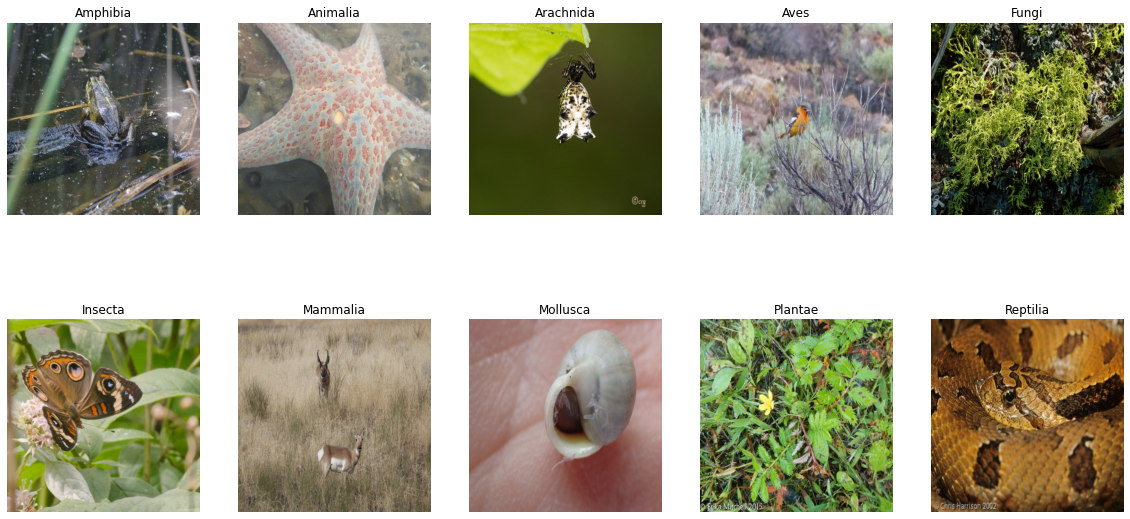

In [5]:
#visualizing images: one from each classes
fig = plt.figure(figsize=(20,10))
rows,columns= 2,5
i=1
for clas in classes: #10 unique classes
  dir=os.path.join(train_dir,clas)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    #image size
    #print(imgs.shape)
    new_img=cv2.resize(imgs,(512,512))
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(clas)
    i+=1   
    break
 

In [6]:
def customized_dataGenerator(h,w):
    img_height,img_width= h ,w
    #data generators for train and validation set
    
    augment= ImageDataGenerator(
             rotation_range=30,
             width_shift_range=0.2,
             height_shift_range=0.2,
             shear_range=0.2,
             zoom_range=0.2,
             horizontal_flip=True,
             rescale=1.0 / 255,
             validation_split=0.1
             )

    datagen = ImageDataGenerator(
              rescale=1.0 / 255,
              validation_split=0.1
              )

    train_set = datagen.flow_from_directory(
                train_dir,
                target_size=(img_height, img_width),
                batch_size=32,
                color_mode='rgb',
                class_mode='sparse',
                shuffle=True,
                subset='training',
                seed=95,
                )
    aug_set= augment.flow_from_directory(
            train_dir,
            target_size=(img_height, img_width),
            batch_size=32,
            color_mode='rgb',
            class_mode='sparse',
            shuffle=True,
            subset='training',
            seed=95,
           )

    val_set= datagen.flow_from_directory(
              train_dir,
              target_size=(img_height, img_width),
              color_mode='rgb',
              class_mode='sparse',
              shuffle=True,
              subset='validation',
              seed=95,
              )
    return train_set, aug_set, val_set


In [7]:
def customized_model(filters,batchnorm,act,fc_size,droprate,h,w):
     model=models.Sequential()
     model.add(Conv2D(filters[0], (3, 3),input_shape=(h,w,3),activation=act))    
     if batchnorm =='yes':
        model.add(BatchNormalization())
     model.add(MaxPooling2D((2, 2)))

     model.add(Conv2D(filters[1], (3, 3),activation=act))
     model.add(MaxPooling2D((2, 2)))

     model.add(Conv2D(filters[2], (3, 3),activation=act))
     model.add(MaxPooling2D((2, 2)))
    
     model.add(Conv2D(filters[3], (3, 3),activation=act))
     model.add(MaxPooling2D((2, 2)))
     
     model.add(Conv2D(filters[4], (3, 3),activation=act))
     if batchnorm =='yes':
        model.add(BatchNormalization())
     model.add(MaxPooling2D((2, 2)))
    
     model.add(Flatten())
     model.add(Dense(fc_size,activation=act)) 
     if batchnorm =='yes':
        model.add(BatchNormalization())
     model.add(Dropout(droprate))
     model.add(Dense(10,activation='softmax')) #Because of classification problem using softmax function 
     model.compile(
          optimizer=tf.keras.optimizers.Adam(),
          loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
          metrics=['accuracy'],
          )
     return model

In [8]:
sweep_config1 = {
  'name': 'sweep1',  
  'method': 'grid',
  'parameters': {
        
        'filters': {
            'values': ['inc_dec','dec_inc','all_64','all_32','inc','dec']
        },
        'fc_size':{
            'values':[128]
        },
        'batchnorm':{
            'values':['yes']
        },
        'augmentation':{
            'values':['yes','No']   
        },
        'droprate':{
            'values':[0.4,0.5]
        }
           
    }

}

sweep_config2 = {
  'name': 'sweep2',  
  'method': 'random',
  'parameters': {
        
        'filters': {
            'values': ['inc_dec','dec_inc','all_64','all_32','inc','dec']
        },
        'fc_size':{
            'values':[128]
        },
        'batchnorm':{
            'values':['yes']
        },
        'augmentation':{
            'values':['yes','No']   
        },
        'droprate':{
            'values':[0.4,0.5]
        }
           
    }

}

config_defaults={
    'filters':'inc',
    'fc_size':256,
    'batchnorm':'yes',
    'augmentation':'no',
    'droprate':0.3
}

In [9]:
def Train_CNN():

  wandb.init(config=config_defaults)
  configs=wandb.config

  configs=config_defaults

  batchnorm=configs['batchnorm']
  droprate=configs['droprate']
  augmentation=configs['augmentation']
  filter_=configs['filters']
  fc_size=configs['fc_size']

  wandb.run.name='filters_'+filter_+'_fc_size_'+str(fc_size)+'_droprate_'+str(droprate)+ str('_bn_' if batchnorm=='yes' else '') +str('augment' if augmentation=='yes' else '')

  if filter_ == 'all_64':
    filters=[64,64,64,64,64]
  elif filter_=='all_32' :
    filters=[32,32,32,32,32]
  elif filter_=='inc' :
    filters=[16,32,64,128,256]
  elif filter_ == 'dec' :
    filters=[128,64,32,16,8]
  elif filter_ =='inc_dec':
    filters=[32,64,128,64,32]
  elif filter_ =='dec_inc' :
    filters=[128,64,32,64,128]


  img_height,img_width=512 ,512
  act = 'relu'
  #preparing model archtecure with the given Q1(A) specifications
  model = customized_model(filters,batchnorm,act,fc_size,droprate,img_height,img_width)
  # Getting the training and validation data using ImageDataGenerator function of keras 
  train_set,aug_set,val_set = customized_dataGenerator(img_height,img_width) 

  if augmentation =='no' :
    hist=model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    #hist=model.fit(train_set,epochs=10,validation_data=val_set)

  else:
    hist=model.fit(aug_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    #hist=model.fit(aug_set,epochs=10,validation_data=val_set)
  
  val_acc=max(hist.history['val_accuracy'])
  params={'batch_norm':batchnorm,'augmentation':augmentation,'dropout':droprate,'filter_architecture':filter_,'val_acc':val_acc}
  wandb.log(params)

In [ ]:
#Using Wandb to do hyperparameter tuning
#After hyperparamter tuning no need to use this piece of code
#sweep_id=wandb.sweep(sweep_config1,entity='rashmipathak',project='assignment_2')
#wandb.agent(sweep_id, Train_CNN)         

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: blasnqi6
Sweep URL: https://wandb.ai/rashmipathak/assignment_2/sweeps/blasnqi6


wandb: Agent Starting Run: 3lq0wuqi with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: inc_dec
wandb: Currently logged in as: rashmipathak (use `wandb login --relogin` to force relogin)


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 205s 683ms/step - loss: 2.3893 - accuracy: 0.2139 - val_loss: 2.7701 - val_accuracy: 0.1081 - _timestamp: 1649323402.0000 - _runtime: 218.0000
Epoch 2/10
282/282 [==============================] - 181s 640ms/step - loss: 2.1181 - accuracy: 0.2788 - val_loss: 2.2045 - val_accuracy: 0.2492 - _timestamp: 1649323583.0000 - _runtime: 399.0000
Epoch 3/10
282/282 [==============================] - 179s 634ms/step - loss: 1.9751 - accuracy: 0.3208 - val_loss: 2.1026 - val_accuracy: 0.2873 - _timestamp: 1649323763.0000 - _runtime: 579.0000
Epoch 4/10
282/282 [==============================] - 176s 623ms/step - loss: 1.8409 - accuracy: 0.3558 - val_loss: 2.1858 - val_accuracy: 0.2883 - _timestamp: 1649323939.0000 - _runtime: 755.0000
Epoch 5/10
282/282 [==============================] - 177s 627ms/step - loss: 1.7096

accuracy,▁▂▂▂▃▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁
val_accuracy,▁▆▇▇█▇▇███
val_loss,▇▂▂▂▁▁▄▄▆█
accuracy,0.928
augmentation,no
batch_norm,yes
best_epoch,5


wandb: Agent Starting Run: 34mzvzij with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 179s 630ms/step - loss: 2.3935 - accuracy: 0.2132 - val_loss: 2.2107 - val_accuracy: 0.1902 - _timestamp: 1649325233.0000 - _runtime: 189.0000
Epoch 2/10
282/282 [==============================] - 178s 629ms/step - loss: 2.1476 - accuracy: 0.2711 - val_loss: 2.0484 - val_accuracy: 0.3103 - _timestamp: 1649325411.0000 - _runtime: 367.0000
Epoch 3/10
282/282 [==============================] - 179s 632ms/step - loss: 1.9990 - accuracy: 0.3081 - val_loss: 2.2449 - val_accuracy: 0.2533 - _timestamp: 1649325590.0000 - _runtime: 546.0000
Epoch 4/10
282/282 [==============================] - 178s 632ms/step - loss: 1.8729 - accuracy: 0.3508 - val_loss: 2.0410 - val_accuracy: 0.2923 - _timestamp: 1649325768.0000 - _runtime: 724.0000
Epoch 5/10
282/282 [==============================] - 178s 630ms/step - loss: 1.7415

accuracy,▁▂▂▂▃▄▄▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁
val_accuracy,▁▆▄▅▅▆▆▆█▆
val_loss,▄▁▅▁▂▂▅▆▆█
accuracy,0.88789
augmentation,no
batch_norm,yes
best_epoch,3


wandb: Agent Starting Run: x7s3rcvp with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: all_64


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 186s 654ms/step - loss: 2.3913 - accuracy: 0.2101 - val_loss: 2.4669 - val_accuracy: 0.1672 - _timestamp: 1649327049.0000 - _runtime: 196.0000
Epoch 2/10
282/282 [==============================] - 182s 644ms/step - loss: 2.1262 - accuracy: 0.2734 - val_loss: 2.1954 - val_accuracy: 0.2402 - _timestamp: 1649327231.0000 - _runtime: 378.0000
Epoch 3/10
282/282 [==============================] - 180s 636ms/step - loss: 1.9835 - accuracy: 0.3169 - val_loss: 2.5510 - val_accuracy: 0.2422 - _timestamp: 1649327411.0000 - _runtime: 558.0000
Epoch 4/10
282/282 [==============================] - 181s 642ms/step - loss: 1.8749 - accuracy: 0.3474 - val_loss: 2.1901 - val_accuracy: 0.3103 - _timestamp: 1649327592.0000 - _runtime: 739.0000
Epoch 5/10
282/282 [==============================] - 179s 634ms/step - loss: 1.7419

accuracy,▁▂▂▂▃▃▄▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁
val_accuracy,▁▄▄▇▆██▇██
val_loss,▅▃▆▃▄▁▂▇▇█
accuracy,0.91133
augmentation,no
batch_norm,yes
best_epoch,5


wandb: Agent Starting Run: 73flr476 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: all_32


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 183s 643ms/step - loss: 2.3913 - accuracy: 0.2126 - val_loss: 2.5959 - val_accuracy: 0.1231 - _timestamp: 1649328903.0000 - _runtime: 192.0000
Epoch 2/10
282/282 [==============================] - 178s 631ms/step - loss: 2.1222 - accuracy: 0.2837 - val_loss: 2.0816 - val_accuracy: 0.2703 - _timestamp: 1649329102.0000 - _runtime: 391.0000
Epoch 3/10
282/282 [==============================] - 177s 626ms/step - loss: 1.9457 - accuracy: 0.3269 - val_loss: 2.0956 - val_accuracy: 0.2753 - _timestamp: 1649329279.0000 - _runtime: 568.0000
Epoch 4/10
282/282 [==============================] - 179s 632ms/step - loss: 1.7982 - accuracy: 0.3789 - val_loss: 1.9759 - val_accuracy: 0.3173 - _timestamp: 1649329457.0000 - _runtime: 746.0000
Epoch 5/10
282/282 [==============================] - 177s 627ms/step - loss: 1.6425

accuracy,▁▂▂▃▃▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁
val_accuracy,▁▆▆██▇█▇██
val_loss,▅▂▂▁▂▂▃▅▅█
accuracy,0.93644
augmentation,no
batch_norm,yes
best_epoch,3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6ylzjpmf with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 180s 632ms/step - loss: 2.3981 - accuracy: 0.2170 - val_loss: 2.5932 - val_accuracy: 0.1231 - _timestamp: 1649330764.0000 - _runtime: 189.0000
Epoch 2/10
282/282 [==============================] - 179s 634ms/step - loss: 2.1253 - accuracy: 0.2771 - val_loss: 2.0646 - val_accuracy: 0.2643 - _timestamp: 1649330943.0000 - _runtime: 368.0000
Epoch 3/10
282/282 [==============================] - 182s 643ms/step - loss: 1.9580 - accuracy: 0.3251 - val_loss: 2.1015 - val_accuracy: 0.2673 - _timestamp: 1649331125.0000 - _runtime: 550.0000
Epoch 4/10
282/282 [==============================] - 180s 637ms/step - loss: 1.8057 - accuracy: 0.3674 - val_loss: 1.9465 - val_accuracy: 0.3173 - _timestamp: 1649331305.0000 - _runtime: 730.0000
Epoch 5/10
282/282 [==============================] - 181s 642ms/step - loss: 1.6517

accuracy,▁▂▂▂▃▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁
val_accuracy,▁▆▆█▇█▆▇██
val_loss,▅▂▂▁▂▂▆▅▇█
accuracy,0.93311
augmentation,no
batch_norm,yes
best_epoch,3


wandb: Agent Starting Run: d60qimbd with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 183s 646ms/step - loss: 2.4262 - accuracy: 0.2144 - val_loss: 2.7964 - val_accuracy: 0.1101 - _timestamp: 1649332629.0000 - _runtime: 194.0000
Epoch 2/10
282/282 [==============================] - 187s 662ms/step - loss: 2.1525 - accuracy: 0.2759 - val_loss: 2.1000 - val_accuracy: 0.2623 - _timestamp: 1649332816.0000 - _runtime: 381.0000
Epoch 3/10
282/282 [==============================] - 185s 656ms/step - loss: 2.0069 - accuracy: 0.3077 - val_loss: 2.0211 - val_accuracy: 0.3143 - _timestamp: 1649333001.0000 - _runtime: 566.0000
Epoch 4/10
282/282 [==============================] - 183s 650ms/step - loss: 1.8838 - accuracy: 0.3468 - val_loss: 2.0449 - val_accuracy: 0.3013 - _timestamp: 1649333185.0000 - _runtime: 750.0000
Epoch 5/10
282/282 [==============================] - 186s 657ms/step - loss: 1.7675

accuracy,▁▂▂▂▃▃▄▅▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▄▂▁
val_acc,▁
val_accuracy,▁▆▇▇▆▇████
val_loss,█▂▁▁▂▂▁▃▃▆
accuracy,0.87111
augmentation,no
batch_norm,yes
best_epoch,6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: woo6cbm7 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.5
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 194s 682ms/step - loss: 2.4031 - accuracy: 0.2197 - val_loss: 2.3961 - val_accuracy: 0.1802 - _timestamp: 1649334577.0000 - _runtime: 203.0000
Epoch 2/10
282/282 [==============================] - 190s 671ms/step - loss: 2.0794 - accuracy: 0.2974 - val_loss: 2.2994 - val_accuracy: 0.2162 - _timestamp: 1649334767.0000 - _runtime: 393.0000
Epoch 3/10
 65/282 [=====>........................] - ETA: 2:15 - loss: 1.8851 - accuracy: 0.3505

In [10]:
#train model with best configs
model=models.Sequential()

img_height,img_width=512,512

model.add(Conv2D(16,(3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 510, 510, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                        

In [11]:
# Getting the training and validation data using ImageDataGenerator function of keras 
train_set,aug_set,val_set = customized_dataGenerator(img_height,img_width) 

Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)

model.fit(aug_set,epochs=9,validation_data=val_set,callbacks=[early_stop])

Epoch 1/9
223/282 [======================>.......] - ETA: 13:15 - loss: 2.6122 - accuracy: 0.1661

KeyboardInterrupt: ignored

In [54]:
#data generator for test set
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
  )

test_set = test_datagen.flow_from_directory(
      test_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=False,
      seed=95,
  )

#evaluating model on test set
model.evaluate(test_set)

Found 2000 images belonging to 10 classes.


In [ ]:
#taking 30 sample images,3 from each class for visualizing

x,y,y_pred=[],[],[]
for clas in classes:
    i=0
    path=os.path.join(test_dir,clas)
    for img in os.listdir(path):
      if i==3:
        break
      try:
        image = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        x.append(image)
        y.append(clas)
        pic = cv2.resize(image, (512,512)) / 255.0
        prediction = model.predict(pic.reshape(1,512, 512,3))
        c=prediction.argmax()
        y_pred.append(classes[c])
        i+=1
      except:
        break

#plotting a 10x3 grid with predictions
fig = plt.figure(figsize=(10,20))
rows,columns=10,3
i=1
for k in range(30):

  img=cv2.resize(x[k],(128,128))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('True:'+y[k]+',Predicted:'+y_pred[k],fontdict={'fontsize':10})
  i+=1   
#wandb.init(entity='rashmi05pathak',project='assignment_2_512by512')
#wandb.log({'predicting on sample images':plt}) 

In [ ]:
#visualizing filters

def fil_vis(lay='conv2d_1'):              #name of 1st conv layer
  fil_model = tf.keras.models.Model(
      inputs = [model.inputs],    
      outputs = [model.get_layer(lay).output]
  )
  category = classes[0]
  dir=os.path.join(test_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(512,512))
    x = np.expand_dims(new_img, axis=0) 
    inputs = tf.cast(x, tf.float32)
    out = fil_model(inputs)[0]

    # plot first few filters
    n_filters, ix = 16, 1
    plt.figure(figsize=(20,20))
    for i in range(n_filters):
      # get the filter
      f = out[:, :, i]
      # plot each channel separately
      for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f)
      ix += 1
    # show the figure
    plt.show()
    break

fil_vis()

#Adding guided backpropogation

In [16]:
LAYER_NAME = 'conv2d_4'
from tensorflow.keras.models import Model

guided_model = Model(inputs=model.inputs, outputs=model.get_layer(LAYER_NAME).output)

In [17]:
guided_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 510, 510, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0     

In [18]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

In [19]:
layer_dict = [layer for layer in guided_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    layer.activation = guidedRelu

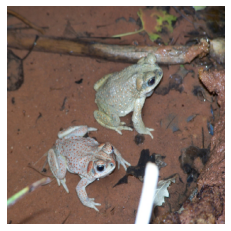

In [58]:
image, label = test_set.next()
plt.imshow(image[0])
plt.axis("off")
plt.show()

In [59]:
with tf.GradientTape() as tape:
    inputs = tf.cast(image, tf.float32)
    tape.watch(inputs)
    outputs = guided_model(inputs)
    
grads = tape.gradient(outputs,inputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


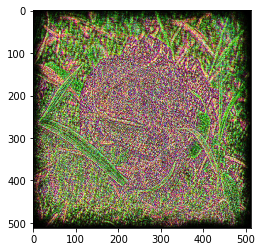

In [61]:
plt.imshow(grads[1])

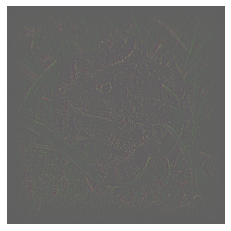

In [63]:
guided_back_prop = grads[1]
final_img = np.dstack((guided_back_prop[:, :, 0], guided_back_prop[:, :, 1], guided_back_prop[:, :, 2],))       
final_img -= np.min(final_img)
final_img /= final_img.max()
    
imgplot = plt.imshow(final_img)
plt.axis("off")
plt.show()

In [64]:
x_list = []
y_list = []
z_list = []
grads = []
while len(grads)!= 10:
    
    x = np.random.randint(4)
    y = np.random.randint(4)
    z = np.random.randint(128)
    
    single_neuron_model = Model(inputs=model.inputs, outputs=model.get_layer(LAYER_NAME).output[:,x,y,z])
    
    layer_dict = [layer for layer in single_neuron_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        layer.activation = guidedRelu
    
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        outputs = single_neuron_model(inputs)
        
    if outputs.numpy()[0] != 0:
        grads.append(tape.gradient(outputs,inputs))
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

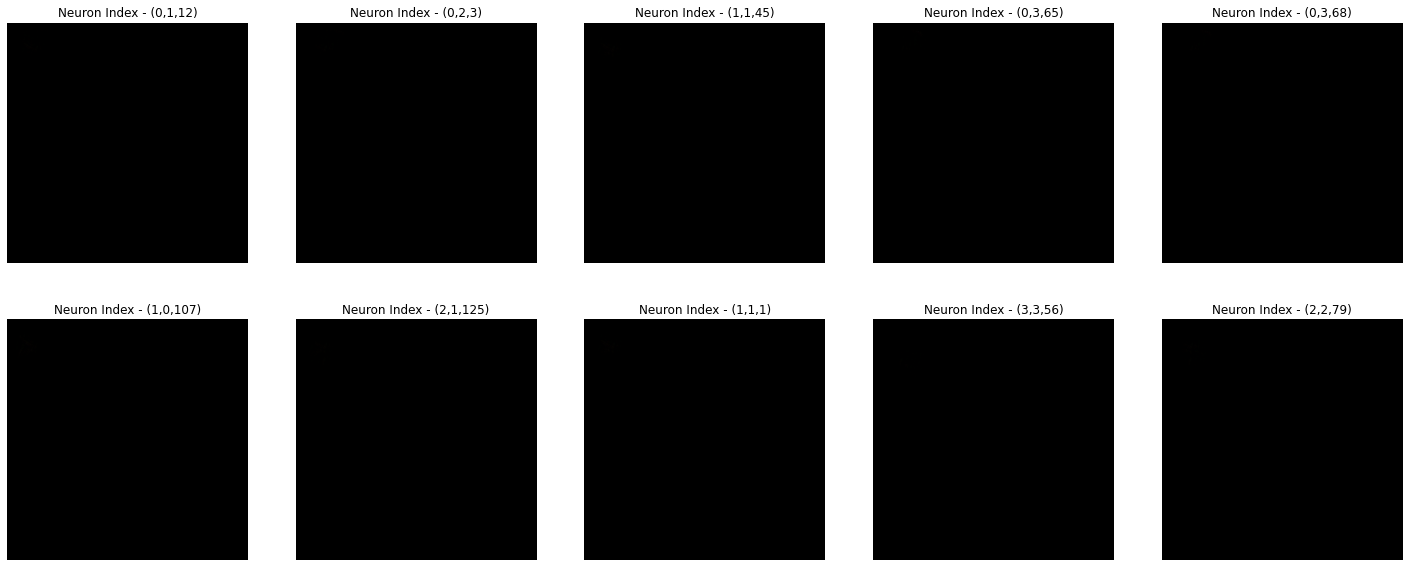

In [67]:
plt.figure(figsize=(25, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(grads[i][1])
    plt.title("Neuron Index - (" + str(x_list[i]) + "," + str(y_list[i]) + "," + str(z_list[i]) + ")")
    plt.axis("off")

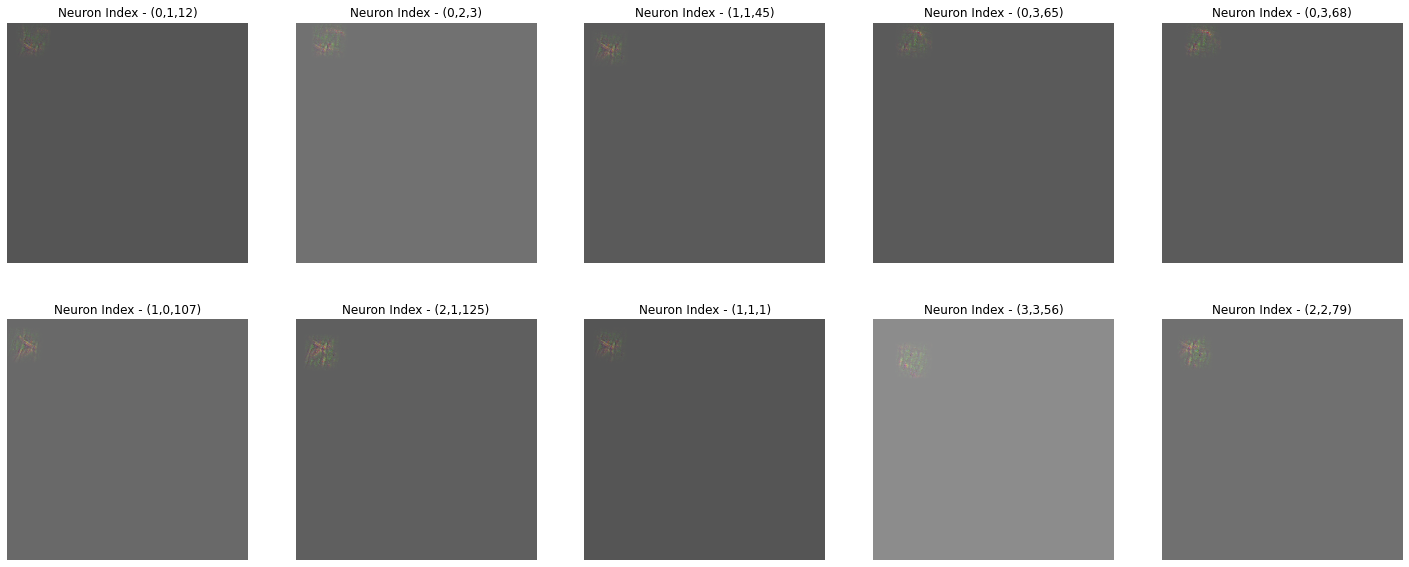

In [68]:
plt.figure(figsize=(25, 10))
for i in range(10):
    guided_back_prop = grads[i][1]
    final_img = np.dstack((guided_back_prop[:, :, 0], guided_back_prop[:, :, 1], guided_back_prop[:, :, 2],))       
    final_img -= np.min(final_img)
    final_img /= final_img.max()
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(final_img)
    plt.title("Neuron Index - (" + str(x_list[i]) + "," + str(y_list[i]) + "," + str(z_list[i]) + ")")
    plt.axis("off")

In [ ]:
plt.imshow(grads[0])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model.save('/content/gdrive/MyDrive/CS6910_Assign2_Models/my_model2')